In [1]:
import pandas as pd
import mplfinance
from matplotlib.dates import date2num
from datetime import datetime
import numpy as np

from scipy import stats
import scipy.optimize
from scipy.optimize import OptimizeWarning
import warnings
import math


import os
import time
import nbimporter
from feature_functions import *
from tensorflow.keras.utils import plot_model

import sklearn
from collections import deque


Importing Jupyter notebook from feature_functions.ipynb


In [2]:
Comission = 8/100000

In [3]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from numpy import sqrt

In [5]:
df=pd.read_csv('EURUSD.csv')
df.columns=['date','open','high','low','close','volume']
df.date = pd.to_datetime(df.date,format='%d.%m.%Y %H:%M:%S.%f')
df=df.set_index(df.date)
df=df[['open','high','low','close','volume']]

In [6]:
df = heikenashi(df,[1])
df.columns=['open','high','low','close']

In [7]:
res = momentum(df,[10]).close[10]
df=df.loc[df.index[10]:]
df['momentum'] = res

In [8]:
def creation_label(variation,comission=Comission):
    if variation > comission:
        return 2
    elif variation< -comission:
        return 1
    else:
        return 0

In [10]:
df['return'] = df['close'] - df['close'].shift(1)

df['label'] = df['return'].shift(-1).apply(lambda var: creation_label(var))

df.dropna(inplace=True)



In [11]:
data = df.loc[:,['momentum','return','label']]

In [12]:
from sklearn import preprocessing

In [13]:
data_norm = data.copy()

In [14]:
momentum_ecartype = data['momentum'].std()
momentum_mean = data['momentum'].mean()
return_ecartype = data['return'].std()
return_mean = np.array(data['return']).mean()

In [15]:
data_norm.loc[:,'momentum'] = data_norm['momentum'] - momentum_mean
data_norm.loc[:,'momentum'] = data_norm['momentum']/momentum_ecartype
data_norm.loc[:,'return'] = data_norm['return'] - return_mean
data_norm.loc[:,'return'] = data_norm['return']/return_ecartype

In [16]:
n_features =60

In [17]:
start = time.time()
sequences = []
prev_hours = deque(maxlen=n_features)

for observation in data_norm.values:
    prev_hours.append([x for x in observation[:-1]])  
    if len(prev_hours) == n_features: 
        sequences.append([np.array(prev_hours), observation[-1]])
        
end = time.time()

print(end - start)


0.2453322410583496


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [19]:
X = np.array([exemple[0] for exemple in sequences])
Y = np.array([int(exemple[1]) for exemple in sequences])

train_len = int(len(sequences)*0.90)
valid_len = int(len(sequences)*0.95)

Y.shape = (Y.shape[0],1)
x_train=X[1:train_len]
y_train=Y[1:train_len]
x_valid = X[train_len:valid_len]
y_valid = Y[train_len:valid_len]
x_test = X[valid_len:]
y_test= Y[valid_len:]
y_train =np.array([int(x) for x in y_train ])
y_valid = np.array([int(x) for x in y_valid ])
y_test = [int(x) for x in y_test ]

In [20]:
from sklearn.preprocessing import LabelEncoder


In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,BatchNormalization

In [23]:
model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1:]), return_sequences=True))
model.add(BatchNormalization())


model.add(LSTM(128,input_shape=(x_train.shape[1:]), return_sequences=True))
model.add(BatchNormalization())


model.add(LSTM(64,input_shape=(x_train.shape[1:]), return_sequences=True))
model.add(BatchNormalization())

model.add(LSTM(64,input_shape=(x_train.shape[1:])))
model.add(BatchNormalization())


model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))

model.add(Dense(3, activation='softmax'))

In [24]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-5)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

In [25]:
BATCH_SIZE = 128
EPOCHS= 40

In [26]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_valid,y_valid),
    batch_size=BATCH_SIZE,
    epochs = EPOCHS)

Train on 5573 samples, validate on 310 samples
Epoch 1/40
5573/5573 [==============================] - 14s 2ms/sample - loss: 1.0847 - accuracy: 0.4061 - val_loss: 1.0896 - val_accuracy: 0.3548
Epoch 2/40
5573/5573 [==============================] - 1s 188us/sample - loss: 1.0534 - accuracy: 0.4114 - val_loss: 1.0849 - val_accuracy: 0.3484
Epoch 3/40
5573/5573 [==============================] - 1s 190us/sample - loss: 1.0469 - accuracy: 0.4242 - val_loss: 1.0913 - val_accuracy: 0.3484
Epoch 4/40
5573/5573 [==============================] - 1s 191us/sample - loss: 1.0447 - accuracy: 0.4260 - val_loss: 1.0928 - val_accuracy: 0.3452
Epoch 5/40
5573/5573 [==============================] - 1s 196us/sample - loss: 1.0440 - accuracy: 0.4159 - val_loss: 1.1038 - val_accuracy: 0.3484
Epoch 6/40
5573/5573 [==============================] - 1s 188us/sample - loss: 1.0409 - accuracy: 0.4324 - val_loss: 1.1070 - val_accuracy: 0.3516
Epoch 7/40
5573/5573 [==============================] - 1s 188us/s

In [27]:
score = model.evaluate(x_test, np.array(y_test), verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.1898013826339475
Test accuracy: 0.5096774


In [27]:
# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()

In [41]:
model.predict(x_test)[2]

array([0.28384927, 0.5921279 , 0.12402279], dtype=float32)

In [35]:
pred = [x.argmax() for x in np.round(model.predict(x_test))]
contracts  = 2000.0

In [36]:
def calc_profit(row):
    if row['won']:
        if row['pred'] != 0:
            return abs(row['return'])*contracts - Comission*contracts
        else:
            return 0
    else:
        if row['pred'] != 0:
            return -abs(row['return'])*contracts - Comission*contracts
        else:
            return 0


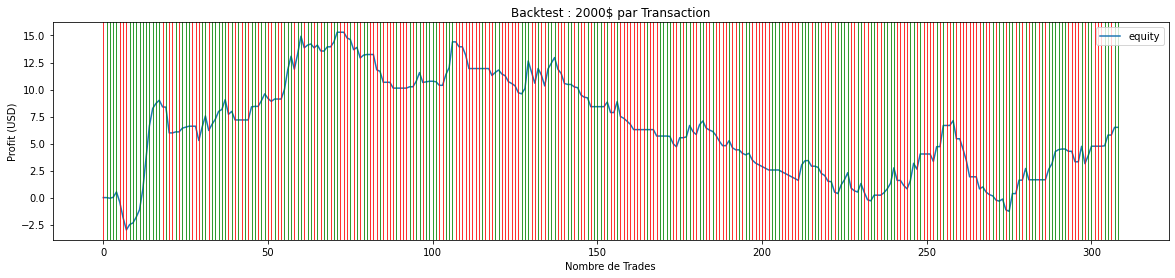

In [37]:
df_trade = pd.DataFrame(np.array(data['return'][valid_len+n_features-1:]), columns=['return'])
df_trade['label']  = y_test
df_trade['pred']   = pred
df_trade['won']    = df_trade['label'] == df_trade['pred']
df_trade.drop(df_trade.index[len(df_trade)-1], inplace=True)

df_trade['pnl'] = df_trade.apply(lambda row: calc_profit(row), axis=1)
df_trade['equity'] = df_trade['pnl'].cumsum()
df_trade.plot(y='equity', figsize=(20,4), title=f'Backtest : {int(contracts)}$ par Transaction')
plt.xlabel('Nombre de Trades')
plt.ylabel('Profit (USD)')
for r in df_trade.iterrows():
    if r[1]['won']:
        plt.axvline(x=r[0], linewidth=1, alpha=0.8, color='g')
    else:
        plt.axvline(x=r[0], linewidth=1, alpha=0.8, color='r')

In [38]:
df_trade

,return,label,pred,won,pnl,equity
0,0.000182,1,0,False,0.000,0.000
1,-0.000117,0,0,True,0.000,0.000
2,-0.000053,1,1,True,-0.055,-0.055
3,-0.000120,1,1,True,0.080,0.025
4,-0.000330,1,1,True,0.500,0.525
...,...,...,...,...,...,...
304,-0.000100,1,1,True,0.040,4.795
305,-0.000575,1,1,True,0.990,5.785
306,-0.000328,1,0,False,0.000,5.785
307,-0.000438,1,1,True,0.715,6.500


Profit Net         : $6.50
Nombre de prédictions justes : 102
Number de prédictions fausses  : 123
Précision    : 45.33%
Moyenne par Transaction Gagnée       : $0.752
Moyenne par Transaction Perdue        : $-0.570
Gain le plus important    : $2.955
Perte la plus importante  : $-2.385


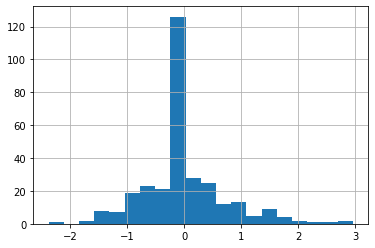

In [39]:
n_win_trades = float(df_trade[df_trade['pnl']>0.0]['pnl'].count())
n_los_trades = float(df_trade[df_trade['pnl']<0.0]['pnl'].count())
print("Profit Net         : $%.2f" % df_trade.tail(1)['equity'])
print("Nombre de prédictions justes : %d" % n_win_trades)
print("Number de prédictions fausses  : %d" % n_los_trades)
print("Précision    : %.2f%%" % (100*n_win_trades/(n_win_trades + n_los_trades)))
print("Moyenne par Transaction Gagnée       : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].mean())
print("Moyenne par Transaction Perdue        : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].mean())
print("Gain le plus important    : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].max())
print("Perte la plus importante  : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].min())

df_trade['pnl'].hist(bins=20)

In [28]:
model.save(f'Modeles/RNN_{time.time()}',save_format='h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 128)           67072     
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 128)           512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 64)            49408     
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 64)            256       
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense (Dense)                (None, 32)                2

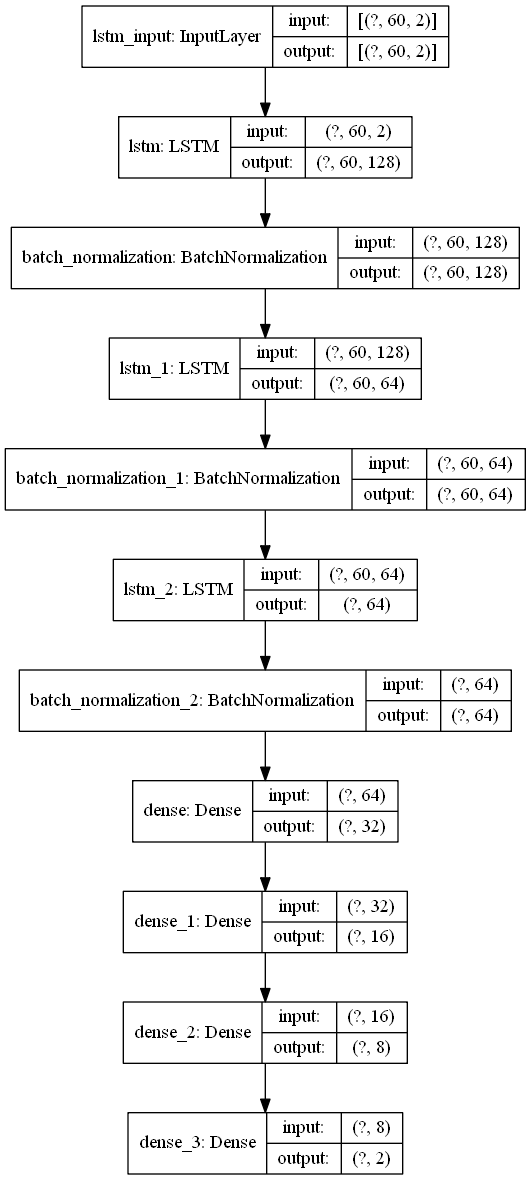

In [29]:
from tensorflow.keras.utils import plot_model
model.summary()
plot_model(model, 'model.png', show_shapes=True)